In [1]:
!pip install vaderSentiment
!pip install pandas numpy nltk matplotlib scikit-learn vaderSentiment yfinance
!pip install --user tensorflow
!pip install --user keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.0 MB/s eta 0:00:00


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf

from tensorflow import keras
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from transformers import pipeline
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


# Dataset (Tweets Sentiment)


In [157]:
tweets = pd.read_csv('tweets.csv', encoding='latin1')
tweets.head()

,token,date,reply_count,like_count,retweet_count,quote_count,text,sentiment_label,sentiment_score
0,bitcoin,2022-01-01 00:00:00.000,20,207,31,3,Most people underestimate the impact #Bitcoin ...,Neutral,0.717482
1,bitcoin,2022-01-01 00:00:00.000,232,3405,286,27,#Bitcoin has started a new yearly candle https...,Neutral,0.810814
2,bitcoin,2022-01-01 00:00:00.000,2,861,12,0,@DESTROYBINARY did people forget that the amog...,Neutral,0.606978
3,bitcoin,2022-01-01 00:00:00.000,18,306,30,9,"In 2017, miners attempted to assert control ov...",Negative,0.510956
4,bitcoin,2022-01-01 00:00:00.000,35,721,35,1,Yearly Close \nMonthly Close\nDaily Close\n\nh...,Positive,0.988296


In [158]:
#Preprocessing
tweets = tweets.drop(['token','reply_count','like_count','retweet_count', 'quote_count', 'sentiment_label','text'], axis=1)

In [159]:
tweets['date'] = pd.to_datetime(tweets['date'])

In [160]:
tweets['DateTime'] = tweets['date'].dt.floor('h')
tweets.head()

,date,sentiment_score,DateTime
0,2022-01-01,0.717482,2022-01-01
1,2022-01-01,0.810814,2022-01-01
2,2022-01-01,0.606978,2022-01-01
3,2022-01-01,0.510956,2022-01-01
4,2022-01-01,0.988296,2022-01-01


In [162]:
vdf = tweets.groupby(pd.Grouper(key='date',freq='H')).size().reset_index(name='tweet_vol')
vdf.head(100)

,date,tweet_vol
0,2022-01-01 00:00:00,114
1,2022-01-01 01:00:00,0
2,2022-01-01 02:00:00,0
3,2022-01-01 03:00:00,0
4,2022-01-01 04:00:00,0
...,...,...
95,2022-01-04 23:00:00,0
96,2022-01-05 00:00:00,79
97,2022-01-05 01:00:00,0
98,2022-01-05 02:00:00,0


In [163]:
vdf.index = pd.to_datetime(vdf.index)
vdf = vdf.set_index('date')
vdf.head()

,tweet_vol
date,
2022-01-01 00:00:00,114
2022-01-01 01:00:00,0
2022-01-01 02:00:00,0
2022-01-01 03:00:00,0
2022-01-01 04:00:00,0


In [164]:
tweets.index = pd.to_datetime(tweets.index)
vdf['tweet_vol'] = vdf['tweet_vol'].astype(float)
tweets.head()

,date,sentiment_score,DateTime
1970-01-01 00:00:00.000000000,2022-01-01,0.717482,2022-01-01
1970-01-01 00:00:00.000000001,2022-01-01,0.810814,2022-01-01
1970-01-01 00:00:00.000000002,2022-01-01,0.606978,2022-01-01
1970-01-01 00:00:00.000000003,2022-01-01,0.510956,2022-01-01
1970-01-01 00:00:00.000000004,2022-01-01,0.988296,2022-01-01


In [167]:
df = tweets.groupby('DateTime').agg(lambda x: x.mean())
df['Tweet_vol'] = vdf['tweet_vol']
df = df.drop(df.index[0])
df.head()

,date,sentiment_score,Tweet_vol
DateTime,,,
2022-01-02,2022-01-02,0.724668,73.0
2022-01-03,2022-01-03,0.758271,76.0
2022-01-04,2022-01-04,0.737739,61.0
2022-01-05,2022-01-05,0.702609,79.0
2022-01-06,2022-01-06,0.702386,88.0


In [168]:
df=df.drop(['date'],axis=1)
df.tail()

,sentiment_score,Tweet_vol
DateTime,,
2023-06-18,0.737353,100.0
2023-06-19,0.725797,100.0
2023-06-20,0.715979,100.0
2023-06-21,0.718877,100.0
2023-06-22,0.720538,100.0




#Dataset (Bitcoin Historical Price)

In [169]:
price = pd.read_csv('BTC-USD (2014-2024).csv', encoding='latin1')
price

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
1,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
2,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
3,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
4,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,2.412760e+07
...,...,...,...,...,...,...,...
3408,2024-01-17,43132.101563,43189.890625,42189.308594,42742.652344,42742.652344,2.085123e+10
3409,2024-01-18,42742.312500,42876.347656,40631.171875,41262.058594,41262.058594,2.521836e+10
3410,2024-01-19,41278.460938,42134.160156,40297.457031,41618.406250,41618.406250,2.575241e+10
3411,2024-01-20,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
price['Date'] = pd.to_datetime(price['Date'])
btc_data = price.set_index(pd.DatetimeIndex(price['Date']))
btc_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2014-09-18,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2014-09-19,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
2014-09-20,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
2014-09-21,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
2014-09-22,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [171]:
btc_data = btc_data.drop(['Date'], axis=1)
Final_df = pd.merge(df, btc_data, how='inner',left_index=True, right_index=True)
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 537 entries, 2022-01-02 to 2023-06-22
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sentiment_score  537 non-null    float64
 1   Tweet_vol        537 non-null    float64
 2   Open             537 non-null    float64
 3   High             537 non-null    float64
 4   Low              537 non-null    float64
 5   Close            537 non-null    float64
 6   Adj Close        537 non-null    float64
 7   Volume           537 non-null    float64
dtypes: float64(8)
memory usage: 37.8 KB


In [172]:
def SMA(df, periods=5):
    lst = []
    for i in range(len(df)):
        if i < periods:
            lst.append(np.nan)
        else:
            lst.append(round(np.mean(df[i:periods+i]), 2))

    return lst

def RSI(df, periods=5):
    df = df.diff()

    lst = []

    for i in range(len(df)):
        if i < periods or i==len(df)-1:
            lst.append(np.nan)
        else:
            avg_gain = (sum([x for x in df[i:periods+i] if x >= 0]) / periods)
            avg_loss = (sum([abs(x) for x in df[i:periods+i] if x <= 0]) / periods)
            if avg_loss==0:
                lst.append(np.nan)
            else:
                rs = avg_gain / avg_loss

                rsi = 100 - (100 / (1 + rs))

                lst.append(round(rsi, 2))
    return lst


In [173]:
Final_df['RSI']=RSI(Final_df['Close'])
Final_df['SMA']=SMA(Final_df['Close'])
Final_df=Final_df[5:]

In [174]:
Final_df[Final_df['RSI']==np.nan]['RSI']=Final_df['RSI'].mean()
Final_df['RSI'][-1]=Final_df['RSI'].mean()
Final_df.tail()

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
2023-06-18,0.737353,100.0,26510.457031,26675.925781,26325.890625,26336.212891,26336.212891,9.565695e+09,92.730000,28290.86
2023-06-19,0.725797,100.0,26335.441406,26984.611328,26312.832031,26851.029297,26851.029297,1.282699e+10,96.980000,28779.52
2023-06-20,0.715979,100.0,26841.664063,28388.968750,26668.791016,28327.488281,28327.488281,2.221186e+10,96.510000,29422.36
2023-06-21,0.718877,100.0,28311.310547,30737.330078,28283.410156,30027.296875,30027.296875,3.334676e+10,93.660000,29969.79
2023-06-22,0.720538,100.0,29995.935547,30495.998047,29679.158203,29912.281250,29912.281250,2.065316e+10,48.562288,29912.28


In [175]:
RSI=Final_df['RSI'].mean()
for i in range(len(Final_df)):
    if np.isnan(Final_df['RSI'][i]):
        Final_df['RSI'][i]=RSI

Final_df.head()

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
2022-01-07,0.706142,77.0,43153.570313,43153.570313,41077.445313,41557.902344,41557.902344,8.419661e+10,42.82,41952.11
2022-01-08,0.708978,58.0,41561.464844,42228.941406,40672.277344,41733.941406,41733.941406,2.806636e+10,96.49,42430.35
2022-01-09,0.739537,73.0,41734.726563,42663.949219,41338.160156,41911.601563,41911.601563,2.129438e+10,61.42,42601.88
2022-01-10,0.738161,74.0,41910.230469,42199.484375,39796.570313,41821.261719,41821.261719,3.210423e+10,64.55,42839.50
2022-01-11,0.708726,61.0,41819.507813,43001.156250,41407.753906,42735.855469,42735.855469,2.632765e+10,66.66,43110.73


#Analysis

In [177]:
cor = Final_df.corr()
cor

,sentiment_score,Tweet_vol,Open,High,Low,Close,Adj Close,Volume,RSI,SMA
sentiment_score,1.000000,-0.180204,0.238381,0.235368,0.253146,0.248155,0.248155,-0.212791,-0.040963,0.239370
Tweet_vol,-0.180204,1.000000,-0.660318,-0.662844,-0.655565,-0.660430,-0.660430,0.024275,-0.002096,-0.657710
Open,0.238381,-0.660318,1.000000,0.997756,0.997015,0.994386,0.994386,-0.032026,-0.134456,0.987146
High,0.235368,-0.662844,0.997756,1.000000,0.996393,0.997453,0.997453,-0.014237,-0.115363,0.990341
Low,0.253146,-0.655565,0.997015,0.996393,1.000000,0.997465,0.997465,-0.065952,-0.116966,0.990325
Close,0.248155,-0.660430,0.994386,0.997453,0.997465,1.000000,1.000000,-0.043563,-0.095671,0.993053
Adj Close,0.248155,-0.660430,0.994386,0.997453,0.997465,1.000000,1.000000,-0.043563,-0.095671,0.993053
Volume,-0.212791,0.024275,-0.032026,-0.014237,-0.065952,-0.043563,-0.043563,1.000000,-0.092751,-0.054591
RSI,-0.040963,-0.002096,-0.134456,-0.115363,-0.116966,-0.095671,-0.095671,-0.092751,1.000000,-0.018628
SMA,0.239370,-0.657710,0.987146,0.990341,0.990325,0.993053,0.993053,-0.054591,-0.018628,1.000000


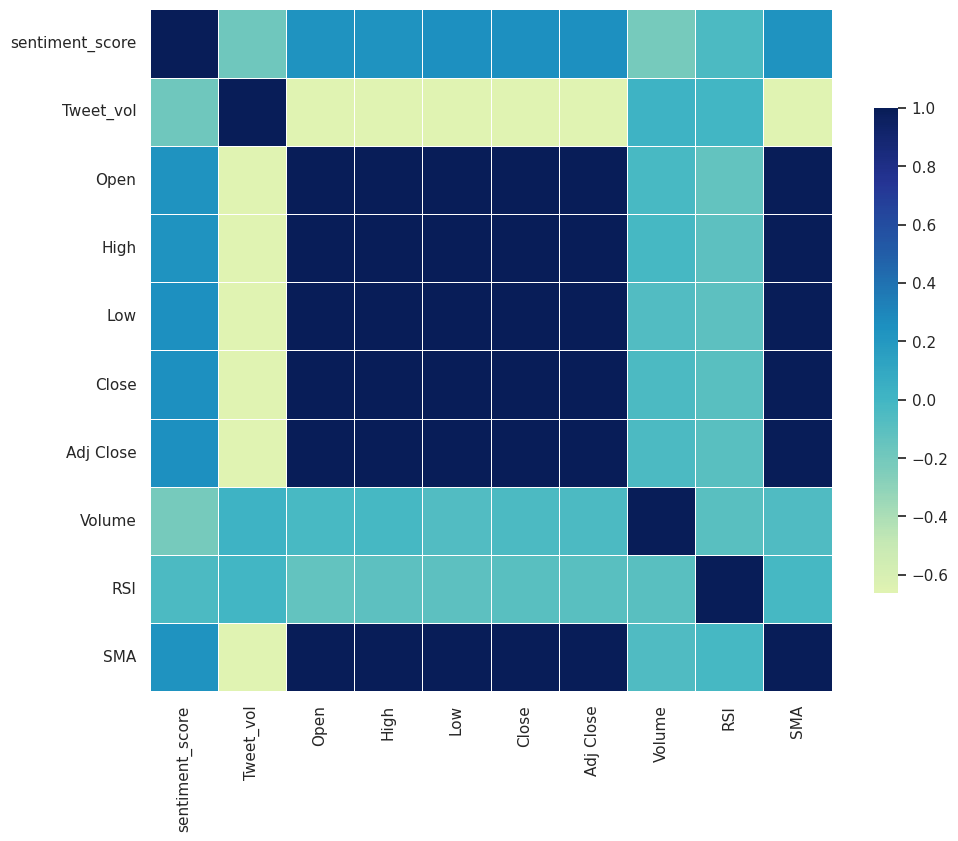

In [178]:
import matplotlib.pyplot as plt
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

ax =sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

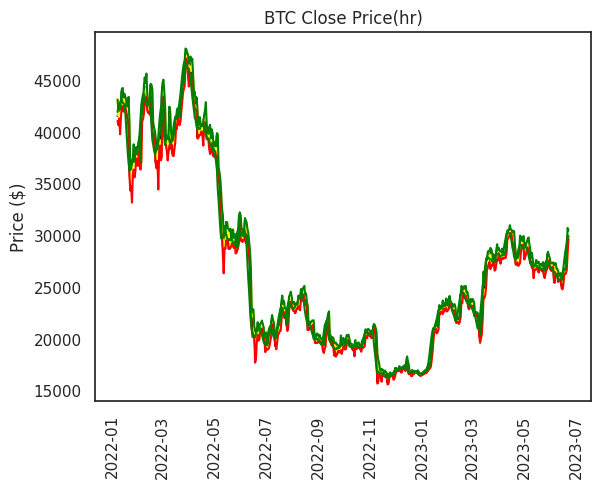

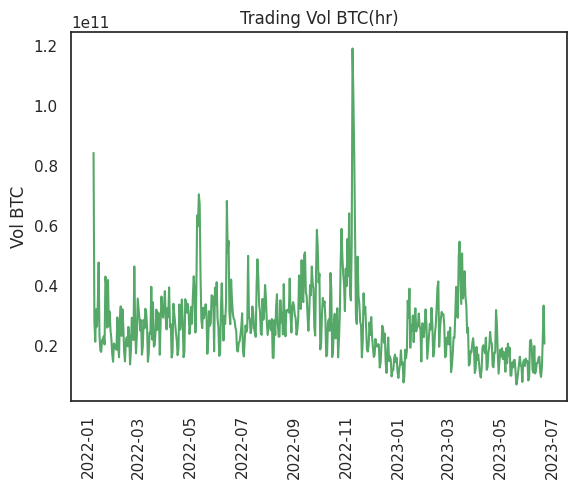

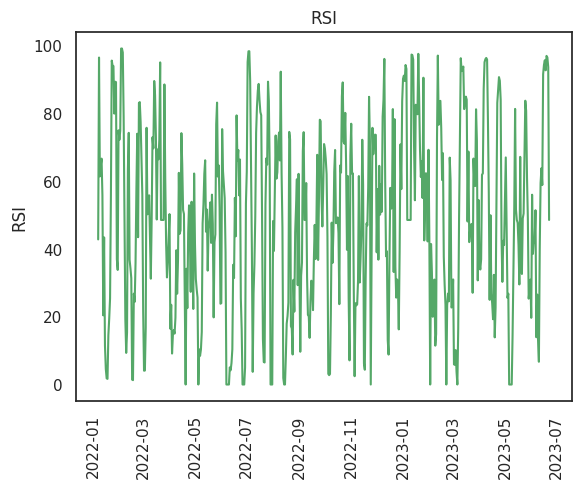

In [179]:
plt.plot(Final_df.index, Final_df['Close'], 'black')
plt.plot(Final_df.index, Final_df['Open'], 'yellow')
plt.plot(Final_df.index, Final_df['Low'], 'red')
plt.plot(Final_df.index, Final_df['High'], 'green')
plt.plot(Final_df.index, Final_df['SMA'], 'green')
plt.title('BTC Close Price(hr)')
plt.xticks(rotation='vertical')
plt.ylabel('Price ($)');
plt.show();

plt.plot(Final_df.index, Final_df['Volume'], 'g')
plt.title('Trading Vol BTC(hr)')
plt.xticks(rotation='vertical')
plt.ylabel('Vol BTC');
plt.show();

plt.plot(Final_df.index, Final_df['RSI'], 'g')
plt.title('RSI')
plt.xticks(rotation='vertical')
plt.ylabel('RSI');
plt.show();

#LSTM

In [180]:
df = Final_df.copy()
df = df.drop(['Open', 'High', 'Low', 'Adj Close'], axis=1)
df.head()

,sentiment_score,Tweet_vol,Close,Volume,RSI,SMA
2022-01-07,0.706142,77.0,41557.902344,8.419661e+10,42.82,41952.11
2022-01-08,0.708978,58.0,41733.941406,2.806636e+10,96.49,42430.35
2022-01-09,0.739537,73.0,41911.601563,2.129438e+10,61.42,42601.88
2022-01-10,0.738161,74.0,41821.261719,3.210423e+10,64.55,42839.50
2022-01-11,0.708726,61.0,42735.855469,2.632765e+10,66.66,43110.73


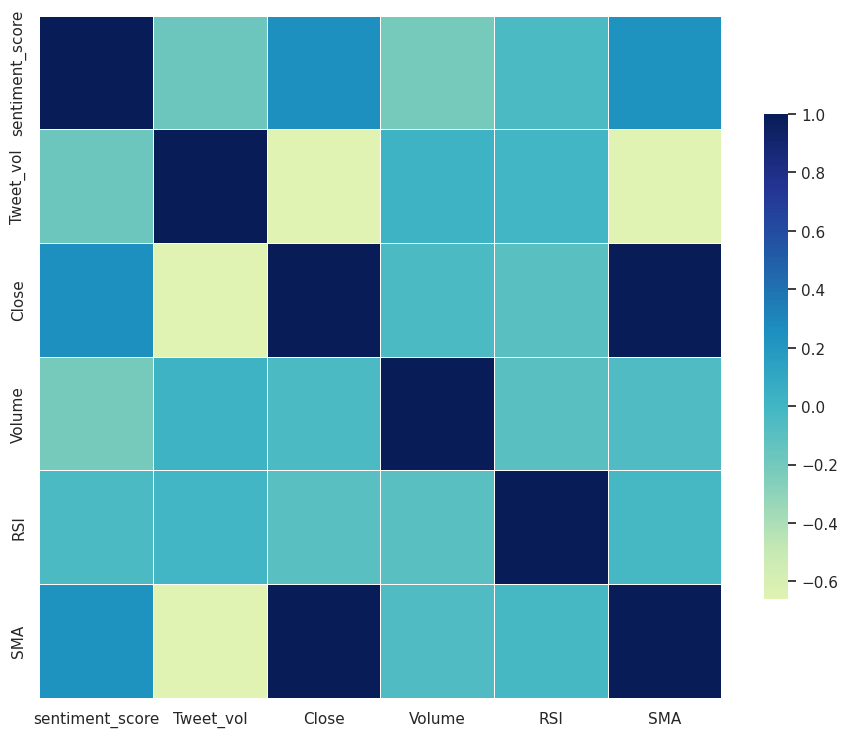

In [181]:
cor = df.corr()
import matplotlib.pyplot as plt
sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

ax =sns.heatmap(cor, cmap="YlGnBu", vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7})
plt.show()

In [192]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [193]:
##PREPARE DATA
from math import sqrt
from pandas import DataFrame
from pandas import concat

# Select features and target
features = df[['sentiment_score', 'Tweet_vol', 'Volume']].values
target = df['Close'].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

n_hours = 3
n_features = 7
n_obs = n_hours*n_features

In [194]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),...,var3(t-1),var4(t-1),var5(t-1),var6(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t)
3,0.471425,0.124661,0.813506,0.689177,0.431827,0.840984,0.495034,0.073171,0.819063,0.187779,...,0.824672,0.127287,0.619403,0.862283,0.737985,0.116531,0.821820,0.223849,0.650968,0.870072
4,0.495034,0.073171,0.819063,0.187779,0.973074,0.856660,0.749443,0.113821,0.824672,0.127287,...,0.821820,0.223849,0.650968,0.870072,0.492932,0.081301,0.850691,0.172248,0.672247,0.878963
5,0.749443,0.113821,0.824672,0.127287,0.619403,0.862283,0.737985,0.116531,0.821820,0.223849,...,0.850691,0.172248,0.672247,0.878963,0.542928,0.094851,0.888990,0.236316,0.563433,0.881442
6,0.737985,0.116531,0.821820,0.223849,0.650968,0.870072,0.492932,0.081301,0.850691,0.172248,...,0.888990,0.236316,0.563433,0.881442,0.453461,0.127371,0.846136,0.363083,0.205829,0.870306
7,0.492932,0.081301,0.850691,0.172248,0.672247,0.878963,0.542928,0.094851,0.888990,0.236316,...,0.846136,0.363083,0.205829,0.870306,0.782807,0.059621,0.862177,0.147681,0.437777,0.868890


In [195]:
reframed.values

array([[0.47142484, 0.12466125, 0.81350638, ..., 0.22384876, 0.65096813,
        0.87007241],
       [0.49503411, 0.07317073, 0.81906344, ..., 0.17224796, 0.67224687,
        0.87896336],
       [0.74944281, 0.11382114, 0.82467168, ..., 0.23631626, 0.56343284,
        0.88144154],
       ...,
       [0.46455604, 0.18699187, 0.3385075 , ..., 0.13548262, 0.97327551,
        0.43025703],
       [0.73126159, 0.18699187, 0.33300019, ..., 0.23494796, 0.94453409,
        0.44820185],
       [0.63505657, 0.18699187, 0.34925151, ..., 0.12155915, 0.48973667,
        0.44631666]])

In [196]:
values = reframed.values
n_train_hours = 200
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(200, 24)

In [197]:
# split into input and outputs
X_train, y_train = train[:, :n_obs], train[:, -n_features]
X_test, y_test = test[:, :n_obs], test[:, -n_features]

X_train = X_train.reshape((X_train.shape[0], n_hours, n_features))
X_test = X_test.reshape((X_test.shape[0], n_hours, n_features))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(200, 3, 7) (200,) (329, 3, 7) (329,)


In [198]:
# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(units=25),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mae')

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - loss: 0.5485 - val_loss: 0.1213
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.2606 - val_loss: 0.4329
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1833 - val_loss: 0.3730
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1477 - val_loss: 0.3025
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1594 - val_loss: 0.3602
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1509 - val_loss: 0.3358
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1515 - val_loss: 0.2919
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1405 - val_loss: 0.3031
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1304 - val_loss: 0.2418
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1170 - val_loss: 0.2635
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1053 - val_loss: 0.1943
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0904 - val_loss: 0.1414


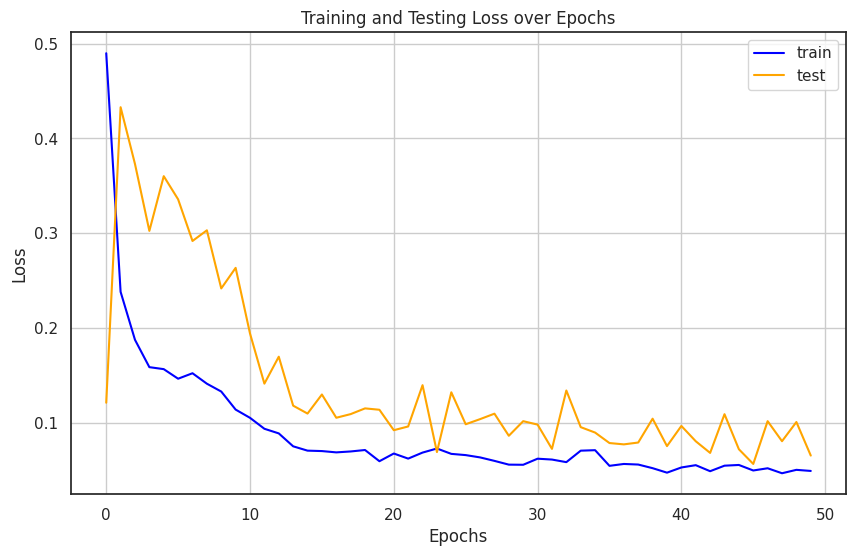

In [199]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='train', color='blue')
plt.plot(test_loss, label='test', color='orange')
plt.title('Training and Testing Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [200]:
print(X_test.shape, y_test.shape, X_train.shape, y_train.shape)

(329, 3, 7) (329,) (200, 3, 7) (200,)


In [201]:
##Evaluating model

# Predict on test data
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [202]:
# LSTM Model
# Inverse transform the predictions and actual values
# Fit the scaler on y_train (assuming it was 1D when fitted)
y_scaler = MinMaxScaler()
y_scaler.fit(y_train.reshape(-1, 1))

# Inverse transform predictions and actual values
y_pred_inv = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = y_scaler.inverse_transform(y_test.reshape(-1, 1))
# Evaluate performance
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'LSTM MAE: {mse}')
# Calculate RMSE
rmse = sqrt(mse)
print('LSTM RMSE: %.3f' % rmse)


# LSTM-RF Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(y_pred, y_test)

# Predict with Random Forest
rf_predictions = rf_model.predict(y_pred)

# Evaluate performance
rf_mse = mean_squared_error(y_test, rf_predictions)
print(f"LSTM-RF MAE: {rf_mse}")
# Calculate LSTM-RF RMSE
rf_rmse = sqrt(rf_mse)
print('LSTM-RF RMSE: %.3f' % rf_rmse)


LSTM MAE: 0.004546561323240173
LSTM RMSE: 0.067
LSTM-RF MAE: 0.0002657461779567074
LSTM-RF RMSE: 0.016


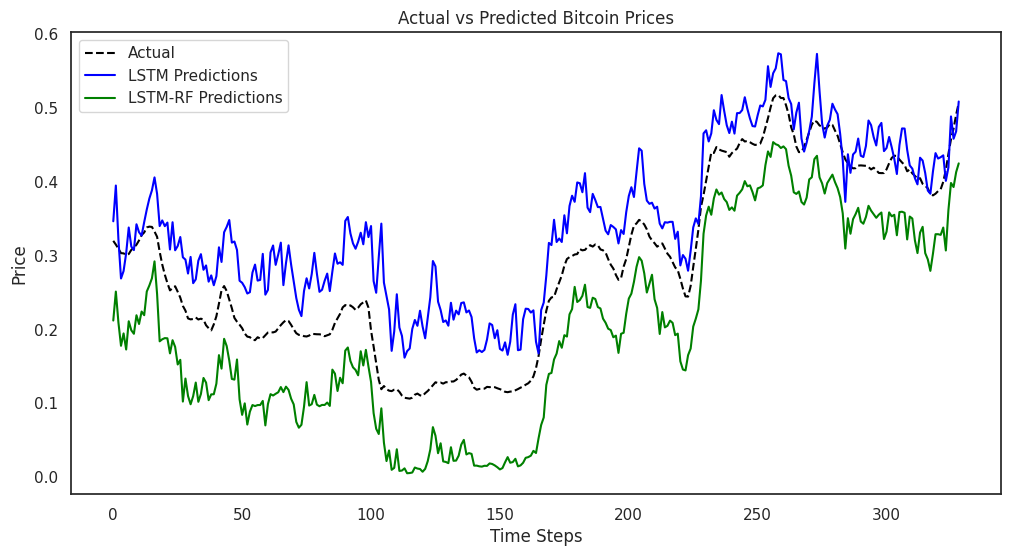

In [203]:
# Plot Actual vs Predicted Prices for LSTM and LSTM-RF
plt.figure(figsize=(12, 6))

# Plot Actual Values
plt.plot(y_test_inv, label='Actual', color='black', linestyle='--')

# Plot LSTM Predictions
plt.plot(y_pred_inv, label='LSTM Predictions', color='blue')

# Plot LSTM-RF Predictions
plt.plot(rf_predictions, label='LSTM-RF Predictions', color='green')

# Add titles and labels
plt.title('Actual vs Predicted Bitcoin Prices')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()